In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence

## klue/bert-base model 및 tokenizer 불러오기

In [2]:
# ==========================================
# 1. 데이터 로드 및 변환 (Train / Validation / Test Split)
# ==========================================

# 파일 경로 설정
train_file_path = "/Users/jian_lee/Desktop/aiffel/data/HuggingFace/ratings_train.txt"
test_file_path = "/Users/jian_lee/Desktop/aiffel/data/HuggingFace/ratings_test.txt"

# 데이터 불러오기
train_df = pd.read_csv(train_file_path, delimiter='\t', keep_default_na=False)
test_df = pd.read_csv(test_file_path, delimiter='\t', keep_default_na=False)

# Train/Validation split (80:20 비율)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# 사용할 모델 이름 지정 (KLUE BERT Base 모델)
MODEL_NAME = "klue/bert-base"

# 사전 학습된 KLUE BERT 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [3]:
# ==========================================
# 2. Bucketing을 고려한 Dataset 및 Collate 함수
# ==========================================

class NSMCBucketingDataset(Dataset):
    """
    NSMC 감성 분석 데이터셋을 PyTorch Dataset 형식으로 변환하는 클래스.
    Bucketing 적용을 위해 문장 길이를 기준으로 정렬하여 배치 구성.
    """
    def __init__(self, data_dict, tokenizer, max_length=128):
        """
        데이터셋 초기화 함수.

        Args:
            data_dict (dict): {"text": 텍스트 리스트, "label": 레이블 리스트}
            tokenizer: KLUE BERT 토크나이저
            max_length (int): 최대 시퀀스 길이 (기본값: 128)
        """
        self.texts = data_dict["text"]
        self.labels = data_dict["label"]
        self.tokenizer = tokenizer
        self.max_length = max_length

        # 문장 길이에 따라 정렬 (길이가 비슷한 샘플끼리 배치하기 위함)
        text_lengths = [len(tokenizer.tokenize(text)) for text in self.texts]
        sorted_indices = np.argsort(text_lengths)  # 길이를 기준으로 정렬
        self.texts = [self.texts[i] for i in sorted_indices]
        self.labels = [self.labels[i] for i in sorted_indices]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], 
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Bucketing을 적용한 Collate 함수 정의 (가변 길이 배치 적용)
def collate_fn(batch):
    input_ids = [item["input_ids"] for item in batch]
    attention_mask = [item["attention_mask"] for item in batch]
    labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)

    # 최대 문장 길이에 맞춰 padding 적용 (가변 길이 지원)
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)

    return {"input_ids": input_ids, "attention_mask": attention_mask, "label": labels}

In [4]:
# ==========================================
# 3. 훈련 및 테스트 데이터셋 생성 (Bucketing 적용)
# ==========================================

# DataFrame을 Python 딕셔너리로 변환
train_dict = {
    "text": train_df["document"].tolist(),
    "label": train_df["label"].tolist(),
}
val_dict = {
    "text": val_df["document"].tolist(),
    "label": val_df["label"].tolist(),
}
test_dict = {
    "text": test_df["document"].tolist(),
    "label": test_df["label"].tolist(),
}

# NSMC 데이터셋을 커스텀 PyTorch Dataset 클래스로 변환
train_dataset = NSMCBucketingDataset(train_dict, tokenizer)
val_dataset = NSMCBucketingDataset(val_dict, tokenizer)
test_dataset = NSMCBucketingDataset(test_dict, tokenizer)

In [5]:
# ==========================================
# 4. DataLoader 설정 (Bucketing 적용)
# ==========================================

# DataLoader를 생성하여 배치 단위로 데이터 로딩
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

print("Bucketing을 적용한 DataLoader 생성 완료")

Bucketing을 적용한 DataLoader 생성 완료


## 모델 학습

In [6]:
# ==========================================
# 5. 모델을 실행할 디바이스 설정 (MPS 지원 추가)
# ==========================================

# Mac MPS 지원을 확인하고, 가능한 경우 GPU 사용
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# 모델 로드 및 디바이스 이동
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

# 옵티마이저 및 손실 함수 설정
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

# 스케줄러 설정 (학습률 감소)
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# ==========================================
# 6. 모델 학습 진행 (Fine-tuning with Bucketing)
# ==========================================

EPOCHS = 3  # 학습 반복 횟수

# Loss 및 Accuracy 저장 리스트 (시각화용)
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    print(f"\n🔹 Epoch {epoch+1}/{EPOCHS}")
    
    # ====== Training ======
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        batch = {key: value.to(device) for key, value in batch.items()}

        outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        loss = criterion(outputs.logits, batch["label"])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Train Loss 저장
    print(f"Training Loss: {avg_train_loss:.4f}")

    # ====== Validation ======
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = {key: value.to(device) for key, value in batch.items()}

            outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            loss = criterion(outputs.logits, batch["label"])
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == batch["label"]).sum().item()
            total += batch["label"].size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total * 100

    val_losses.append(avg_val_loss)  # Validation Loss 저장
    val_accuracies.append(val_accuracy)  # Validation Accuracy 저장

    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

print("\nBucketing 적용 Fine-tuning 완료!")


🔹 Epoch 1/3


100%|██████████| 7500/7500 [31:56<00:00,  3.91it/s]


Training Loss: 0.0491
Validation Loss: 0.3310
Validation Accuracy: 90.11%

🔹 Epoch 2/3


100%|██████████| 7500/7500 [32:06<00:00,  3.89it/s]


Training Loss: 0.0489
Validation Loss: 0.3310
Validation Accuracy: 90.11%

🔹 Epoch 3/3


100%|██████████| 7500/7500 [32:03<00:00,  3.90it/s]


Training Loss: 0.0486
Validation Loss: 0.3310
Validation Accuracy: 90.11%

Bucketing 적용 Fine-tuning 완료!


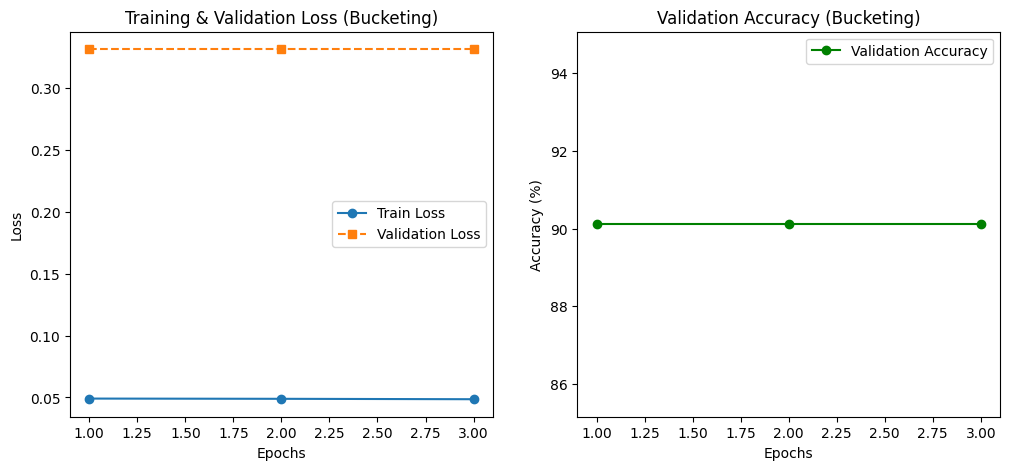

In [12]:
# ==========================================
# 7. Loss 및 Accuracy 시각화 (기존 모델 vs Bucketing 적용 모델)
# ==========================================

# 학습된 Loss 및 Accuracy 리스트를 Bucketing 모델과 기존 모델 변수로 정리
bucketing_train_losses = train_losses  # Bucketing 모델의 Training Loss
bucketing_val_losses = val_losses  # Bucketing 모델의 Validation Loss
bucketing_val_accuracies = val_accuracies  # Bucketing 모델의 Validation Accuracy

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, len(bucketing_train_losses) + 1), bucketing_train_losses, label="Train Loss", marker="o", linestyle="-")
plt.plot(range(1, len(bucketing_val_losses) + 1), bucketing_val_losses, label="Validation Loss", marker="s", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss (Bucketing)")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, len(bucketing_val_accuracies) + 1), bucketing_val_accuracies, label="Validation Accuracy", marker="o", linestyle="-", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy (Bucketing)")
plt.legend()

# 그래프 표시
plt.show()

## 테스트 데이터 평가

In [14]:
# ==========================================
# 1. Bucketing 적용된 테스트 데이터 전처리
# ==========================================

# `test_df`를 올바른 딕셔너리 형태로 변환
test_dict = {
    "text": test_df["document"].tolist(),  # 'document' 컬럼을 'text'로 변경
    "label": test_df["label"].tolist(),
}

# Bucketing을 적용한 테스트 데이터셋 변환
test_dataset_bucketing = NSMCBucketingDataset(test_dict, tokenizer)

# Bucketing을 적용한 DataLoader (collate_fn 적용)
test_loader_bucketing = DataLoader(test_dataset_bucketing, batch_size=16, shuffle=False, collate_fn=collate_fn)

print("Bucketing 적용된 테스트 데이터셋 및 DataLoader 생성 완료")

Bucketing 적용된 테스트 데이터셋 및 DataLoader 생성 완료


In [15]:
# ==========================================
# 2. Bucketing 모델 평가 (Test Set)
# ==========================================

# 모델을 평가 모드로 설정
model.eval()

# 테스트 손실 및 정확도 변수 초기화
test_loss_bucketing = 0
correct_bucketing = 0
total_bucketing = 0

# 손실 함수 (이전과 동일하게 사용)
criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():  # 평가 시에는 Gradient 계산 X
    for batch in test_loader_bucketing:
        batch = {key: value.to(device) for key, value in batch.items()}

        # 모델 예측 수행
        outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        loss = criterion(outputs.logits, batch["label"])
        test_loss_bucketing += loss.item()

        # 예측 결과 확인
        preds = torch.argmax(outputs.logits, dim=1)
        correct_bucketing += (preds == batch["label"]).sum().item()
        total_bucketing += batch["label"].size(0)

# 평균 테스트 손실 및 정확도 계산
avg_test_loss_bucketing = test_loss_bucketing / len(test_loader_bucketing)
test_accuracy_bucketing = correct_bucketing / total_bucketing * 100

In [17]:
# ==========================================
# 3. 테스트 결과 비교 출력
# ==========================================

print("\nBucketing 모델 테스트 데이터 평가 완료!")
print(f"Test Loss (Bucketing): {avg_test_loss_bucketing:.4f}")
print(f"Test Accuracy (Bucketing): {test_accuracy_bucketing:.2f}%")


Bucketing 모델 테스트 데이터 평가 완료!
Test Loss (Bucketing): 0.3259
Test Accuracy (Bucketing): 90.22%


---

## 회고

- 기존 모델에 비해 시간이 단축된 모습을 볼 수 있음.
    - 기존 모델은 1시간 이상 걸렸지만 30분 만에 학습이 완료됨.

- 성능은 큰 차이가 없음.